<h1 align="center">Textual Inversion with Diffusers Library</h1> 

This code is copied from https://github.com/huggingface/diffusers/tree/main/examples/textual_inversion
 
## Training

For training run the following code in your terminal. Note that this code requires a source install of the diffusers library (see diffusers repo for more details).

```
accelerate config

huggingface-cli login

accelerate launch textual_inversion.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir="data/selfies" \
  --learnable_property="object" \
  --placeholder_token="<CHRIS>" --initializer_token="person" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=1000 \
  --learning_rate=5.0e-04 --scale_lr \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --output_dir="data/textual_inversion/selfies"
```

## Inference

In [1]:
import torch
from diffusers import StableDiffusionPipeline, PNDMScheduler
import matplotlib.pyplot as plt

model_id = "data/textual_inversion/chris"
pipe = StableDiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float16).to("cuda")
pipe.scheduler = PNDMScheduler.from_config(pipe.scheduler.config)

/home/chris/miniconda3/envs/diffusers/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chris/miniconda3/envs/diffusers/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [2]:
def make_linebreaks(prompt, max_length=40):
    i=1
    do_linebreak = False
    new_title = ""
    for x in prompt:
        if i%40==0:
            do_linebreak = True
        if x == " " and do_linebreak:
            new_title += "\n"
            do_linebreak = False
        else:
            new_title += x
        i+=1
    return new_title

100%|██████████| 150/150 [00:23<00:00,  6.28it/s]


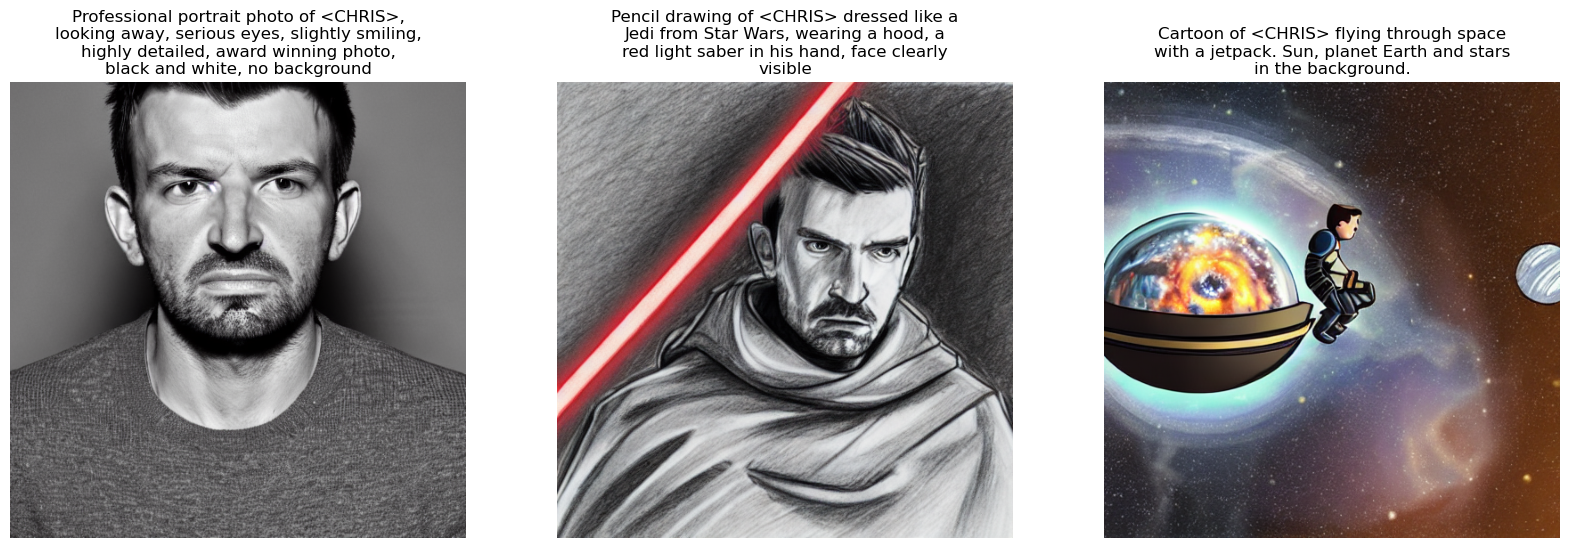

In [3]:
prompts_and_seeds = [
    ("Professional portrait photo of <CHRIS>, looking away, serious eyes, slightly smiling, highly detailed, award winning photo, black and white, no background", 2),
    ("Pencil drawing of <CHRIS> dressed like a Jedi from Star Wars, wearing a hood, a red light saber in his hand, face clearly visible", 1011),
    ("Cartoon of <CHRIS> flying through space with a jetpack. Sun, planet Earth and stars in the background.", 1000)
]

prompts = [prompt for prompt, _ in prompts_and_seeds]
generator = [torch.Generator(device="cuda").manual_seed(seed) for _, seed in prompts_and_seeds]

ret = pipe(prompts, num_inference_steps=150, guidance_scale=7.5, generator=generator, output_type="np.ndarray")

fig, axs = plt.subplots(1, len(prompts), figsize=(20, 20))
for ax, image, prompt in zip(axs, ret.images, prompts):
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(make_linebreaks(prompt, max_length=40))
plt.show()